I import numpy for working with arrays, cv2 and imutils for image processing and google.colab.patches.cv2_imshow for image showing.


In [ ]:
import numpy as np
import cv2, imutils
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow

Here you can specify your variables.<br />
*prototxt* - path to file with weights for NN<br />
*model* - model(NN architecture)<br />
*image_path* - path to your image<br />
*user_confidence* - minimal confidence of NN prediction

In [ ]:
prototxt = "/content/drive/My Drive/BlurNN/deploy.prototxt.txt"
model = "/content/drive/My Drive/BlurNN/res10_300x300_ssd_iter_140000.caffemodel"
image_path = "/content/drive/My Drive/BlurNN/image.jpg"
user_confidence = 0.5

Image processing function. It takes image, boxes, mode and isFrame param.

In [ ]:
def is_ellipse(x, y, x_c, y_c, A, B):   
  print((x - x_c)**2 / A**2, (y - y_c)**2 / B**2)
  return ((x - x_c)**2 / A**2 + (y - y_c)**2 / B**2) <= 1

def process(image, boxes, mode = "around", isFrame = False):
    # mode: around, face
    faces = []
    face_points = ([], ([], []))

    try:
      for box in boxes:
        (startX, startY, endX, endY) = box[0].astype('int') # getting face position
        for y in range(startY, endY):
          for x in range(startX, endX):
            if (is_ellipse(x, y, (startX + endX) / 2, (startY + endY) / 2, abs((startX - endX) / 2) + 3, abs((startY - endY) / 2) + 3)):
              face_points[0].append(image[y][x])
              face_points[1][0].append(y)
              face_points[1][1].append(x)
        faces.append((startY, endY, startX, endX, box[1])) # area with face
    except:
      pass
      
    if (mode == "around"):
      image_copy = image.copy()

      np.delete(image_copy, face_points[0]) # removing area withour blur from image

      image_copy = cv2.GaussianBlur(image_copy, (51, 51), 0) # making gaussian blur

      image_copy[face_points[1][0], face_points[1][1]] = image[face_points[1][0], face_points[1][1]] # pushing without blur territory to blur image
      image = image_copy
    elif (mode == "face"):
      try:
        image[face_points[1][0], face_points[1][1]] = cv2.GaussianBlur(image[face_points[1][0], face_points[1][1]], (51, 51), 0) # making gaussian blur at face area
      except:
        pass
        
    if (isFrame):
      for imageParams in faces:
        text = "{:.2f} %".format(imageParams[4] * 100) # making text with confidence
        textY = imageParams[0] - 10 if imageParams[0] - 10 > 10 else imageParams[0] + 10 # calculating text position
        cv2.rectangle(image, (imageParams[2], imageParams[0]), (imageParams[3], imageParams[1]), (255, 255, 255), 1)
        cv2.putText(image, text, (imageParams[2], textY), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 0.45, (0, 0, 255), 1)
    return image


# Recognizing and processing face.

<h2>Processing</h2>
I use <b>process</b> function.<br />
There are two modes:<br />
*around* - blur will be around face on image;<br />
*face* - blur will be on face.<br />
<br />
*isFrame* param creates frame and confidence text around face.

<h2>Examples:</h2>

Getting image with frame and with blur around face
```
image = process(image, box, confidence, mode = "around", isFrame = True)
```
Getting image without frame and with blur on face
```
image = process(image, box, confidence, mode = "face", isFrame = True)
```

Streaming output truncated to the last 5000 lines.
0.2394748755092802 0.021415823914336704
0.19963784517881394 0.021415823914336704
0.16342236306020824 0.021415823914336704
0.1308284291534631 0.021415823914336704
0.10185604345857854 0.021415823914336704
0.07650520597555455 0.021415823914336704
0.05477591670439113 0.021415823914336704
0.03666817564508828 0.021415823914336704
0.022181982797645994 0.021415823914336704
0.011317338162064282 0.021415823914336704
0.004074241738343142 0.021415823914336704
0.0004526935264825713 0.021415823914336704
0.0004526935264825713 0.021415823914336704
0.004074241738343142 0.021415823914336704
0.011317338162064282 0.021415823914336704
0.022181982797645994 0.021415823914336704
0.03666817564508828 0.021415823914336704
0.05477591670439113 0.021415823914336704
0.07650520597555455 0.021415823914336704
0.10185604345857854 0.021415823914336704
0.1308284291534631 0.021415823914336704
0.16342236306020824 0.021415823914336704
0.19963784517881394 0.021415823914336704

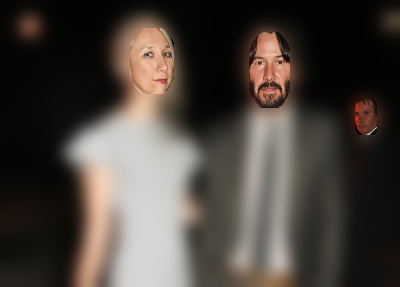

In [ ]:
  image = cv2.imread(image_path)
  
  image = imutils.resize(image, width=400)

  (h, w) = image.shape[:2]

  net = cv2.dnn.readNetFromCaffe(prototxt, model)

  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0)) # getting blob from image(last argument is magic numbers :/ )

  print("detection...")

  net.setInput(blob) # giving blob to NN
  detections = net.forward() # getting prediction

  boxes = []
  for i in range(detections.shape[2]):
    confidence = detections[0, 0, i, 2]

    if (confidence > user_confidence):
      boxes.append((detections[0, 0, i, 3:7] * np.array([w, h, w, h]), confidence)) # getting positions by slicing detections array, then we multiply it to [w, h, w, h] array to get full-size image
  image = process(image, boxes, mode = "around", isFrame = False) # processing

  cv2_imshow(image)